In [25]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary


from sklearn.metrics import classification_report



import warnings
warnings.filterwarnings('ignore')

In [26]:
###------------------------------
### Plot Loss Curve using pytorch
###------------------------------
def fn_plot_torch_hist(hist_df):

    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]

    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset='test_loss')
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot

    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow


    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(),
               color = 'green',
               linestyle='-.', lw = 3)

    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()




In [27]:
 # Global Variables

RANDOM_STATE = 24
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

NOISE = 0.2
EPOCHS = 2001
ALPHA = 0.001
BATCH_SIZE = 256
TEST_SIZE = 3811 #18147 - 56*256
LR_FACTOR = 0.1
LR_PATIENCE = 10

# set the plotting parameters
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')



**LOAD DATA**

In [28]:
#Loading the datset
data_df = pd.read_csv('/content/fashion-mnist_train.csv')
test_df = pd.read_csv('/content/fashion-mnist_test.csv')

In [29]:
class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

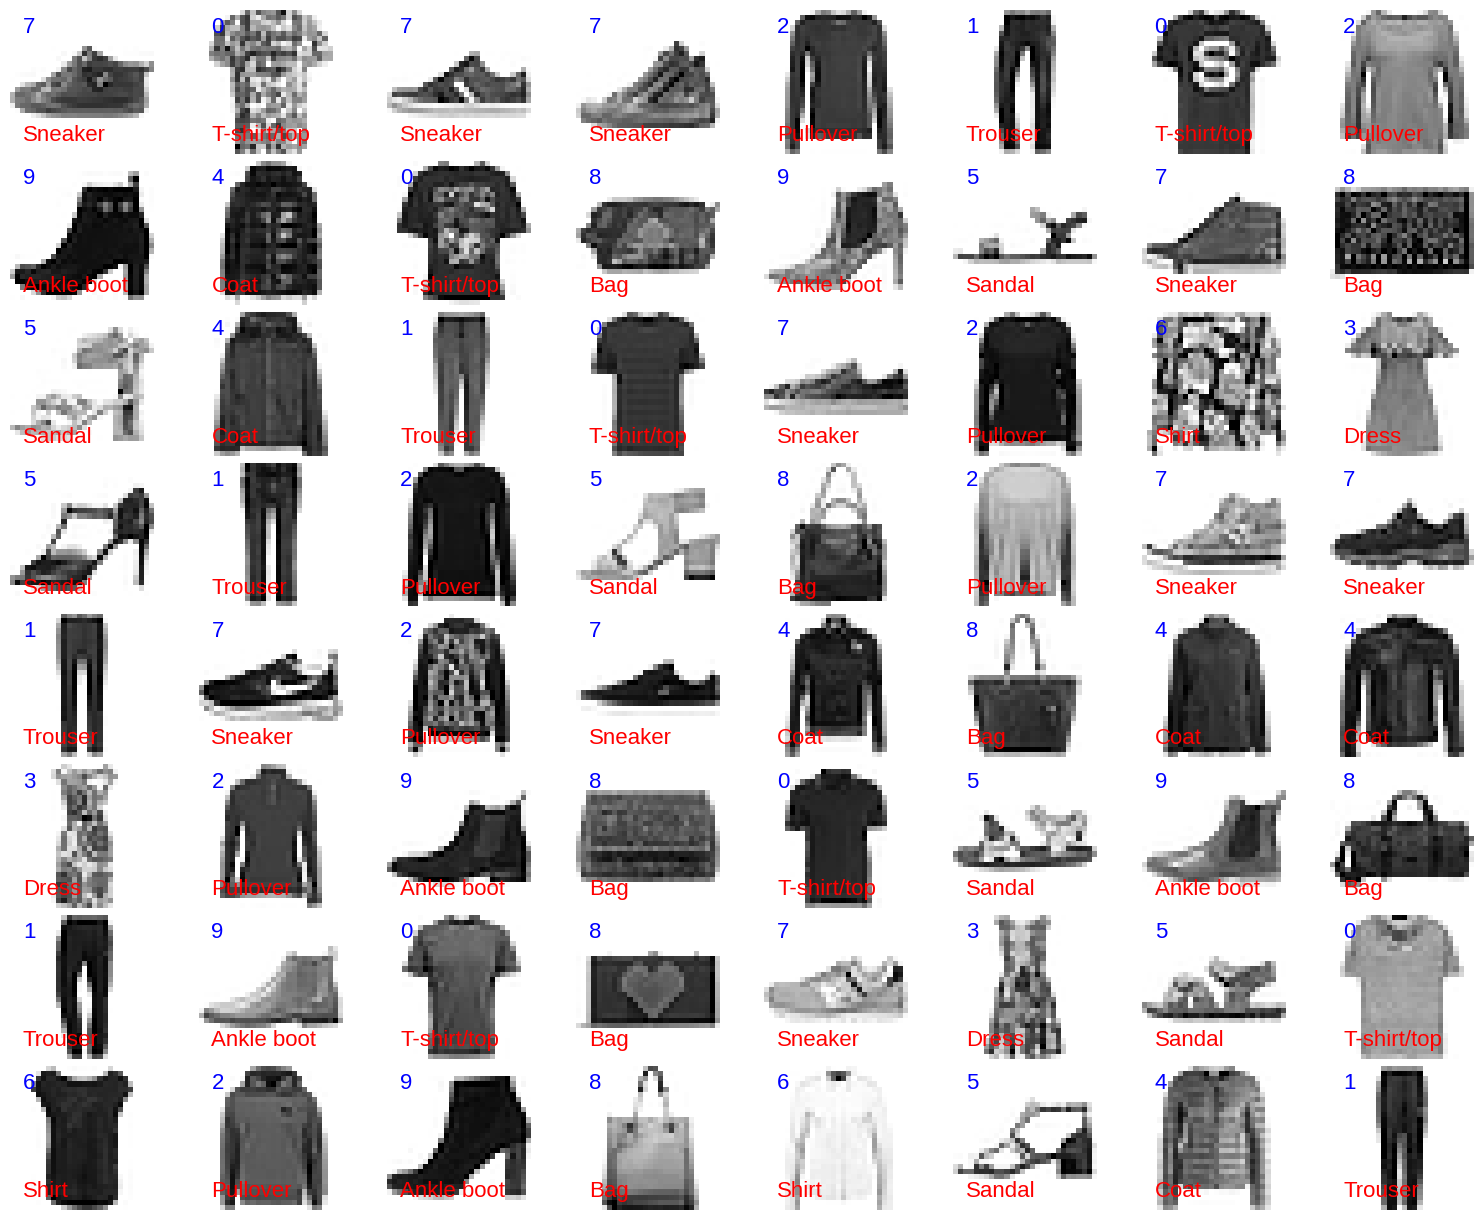

In [30]:

n_rows = 8 # number of rows to display in the grid
n_cols = 8 # number of columns to display in grid

# randomly sample n_rows * n_cols images from the dataset
plot_df = data_df.sample(n = n_rows*n_cols)

# create a new figure for the grid of images with specified sizes
fig = plt.figure(figsize = (15, 12))

# adjust spacing between subplots to eliminate gaps
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

# initialize the subplot index
i = 0

# iterate through each row of teh sampled dataframe

for idx, row in plot_df.iterrows():

    i += 1 # incrimant subplot index

    # reshaping the row values (excluding the first columns) into a 28*28 matirx(image dimensions as given))
    image = row.values[1:].reshape(28,28)

    ax = fig.add_subplot(n_rows, n_cols, (i), xticks = [], yticks = []) # No ticks for a clean plot

    # display the image on the subplot using a binary colormap
    ax.imshow(image, cmap = plt.cm.binary, interpolation = 'nearest')

    # add the numeric label of the image in blue text at a specific possition
    ax.text(2, 4, str(row.iloc[0]), color = 'b', fontsize = 16)

    # add the class nameof the image in red text below the numeric label
    ax.text(2, 25, class_names[row.iloc[0]], color = 'r', fontsize = 16)

plt.show()

In [31]:
# Splitting train test data  using data_df

X_data = data_df.drop('label', axis = 1).to_numpy()
y_data = data_df['label'].to_numpy()

X_train,X_test,y_train,y_test = train_test_split(X_data, y_data, test_size = TEST_SIZE,
                                                 stratify=y_data, random_state=RANDOM_STATE)


# splitting validation data using test_df
X_valid = test_df.drop('label', axis = 1).to_numpy()
y_valid = test_df['label'].to_numpy()


X_train.shape, X_test.shape, y_train.shape, y_test.shape,X_valid.shape ,y_valid.shape

((56189, 784), (3811, 784), (56189,), (3811,), (10000, 784), (10000,))

In [32]:
X_train = X_train /255.0
X_test = X_test /255.0
X_valid = X_valid / 255.0

In [33]:
#Convertong into tensorflow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

In [34]:
train_shape = X_train.shape
test_shape = X_test.shape
valid_shape = X_valid.shape

In [35]:
# Shuffle and batch the Dataset
# by chaniging these opeartions (shuffle and batch) the dataset is first shuffle
#  and then dic=vided into batche making it ready for training ready


train_ds = train_ds.shuffle(buffer_size=X_train.shape[0]).batch(BATCH_SIZE)  #when you ran out of memory then you'll need to do this
test_ds = test_ds.shuffle(buffer_size=X_test.shape[0]).batch(BATCH_SIZE)
valid_ds = valid_ds.shuffle(buffer_size=X_valid.shape[0]).batch(BATCH_SIZE)

In [36]:
# optimize for performance
# cache the data to avoid redundant process
# repeat the dataset for multiple blocks
# prefetch data to ovelap preprocessing and model execution


train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

Custom Datasets

In [37]:
''' Define custom dataset'''
class FifaDataset(Dataset):
  def __init__(self, X, y):
    super(FifaDataset,self).__init__()
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.long)
  def __len__(self):
    return(len(self.X))
  def __getitem__(self, idx):
    return(self.X[idx], self.y[idx])

In [38]:
train_dataset = FifaDataset(X_train, y_train)
test_dataset = FifaDataset(X_test, y_test)

test_loader = DataLoader(dataset=train_dataset,
                          shuffle=True,
                          batch_size=BATCH_SIZE, )

train_loader = DataLoader(dataset=train_dataset,
                          shuffle=True,
                          batch_size=BATCH_SIZE, )

X_batch, y_batch = next(iter(train_loader))

X_batch.shape, y_batch.shape


(torch.Size([256, 784]), torch.Size([256]))

Is Environment Ok

In [39]:
torch.cuda.is_available()

False

In [40]:
torch.version.cuda

'12.1'

In [41]:
#torch.cuda.get_device_name(torch.cuda.current_device())

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [43]:
input_dim= X_train.shape[1]

class Model(nn.Module):

  #Dropout
  #BatchNorm
  def __init__(self, input_dim):
    super(Model, self).__init__()
    dor1=0.1
    #Set1
    self.layer1 = nn.Linear(input_dim,18)
    self.actv1 = nn.ReLU()
    self.do1 = nn.Dropout(dor1)
    self.bn1 = nn.BatchNorm1d(18)
    #Set 2
    self.layer2 = nn.Linear(18,4)

  def forward(self, x):
    #Set1
    x = self.layer1(x)
    x = self.bn1(x)
    x = self.actv1(x)
    x = self.do1(x)
    #Set2
    x = self.layer2(x)
    return x

model = Model (input_dim).to(device)



print(model)

Model(
  (layer1): Linear(in_features=784, out_features=18, bias=True)
  (actv1): ReLU()
  (do1): Dropout(p=0.1, inplace=False)
  (bn1): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=18, out_features=4, bias=True)
)


In [44]:
#summary(model,(1,33))

In [45]:
for param in list(model.parameters()):
  print(param.shape)

torch.Size([18, 784])
torch.Size([18])
torch.Size([18])
torch.Size([18])
torch.Size([4, 18])
torch.Size([4])


In [48]:
#Loss Function
loss_fn = nn.CrossEntropyLoss()
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode= 'min',
                                                       factor=LR_FACTOR,
                                                       patience=LR_PATIENCE,
                                                       min_lr =ALPHA-5)

# some lists to collect progress
loss = []
tloss=[]
n_epoch =[]
acc= []
tacc= []

#loop for defined epochs
for epoch in range(EPOCHS):
    model.train()  #set your model in train mode
    epoch_loss = 0
    epoch_acc = 0
    tepoch_loss = 0
    tepoch_acc = 0


    for batch_idx, (train_X, train_y) in enumerate(train_loader):
      train_X= train_X.to(device)
      train_y= train_y.to(device)
      predict_proba = model(train_X) #make predictions

      # Check for and correct out-of-bounds target values
      train_y = torch.clamp(train_y, 0, 3)  # Clamps target values to be within 0-3

      batch_loss= loss_fn(predict_proba, train_y) #calculate loss
      epoch_loss +=(batch_loss -epoch_loss)/(batch_idx+1) #Calculate running mean

      # Backpropagation
      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()
      y_pred = predict_proba.argmax(dim=1).cpu().numpy()
      batch_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
      epoch_acc +=(batch_acc -epoch_acc)/(batch_idx+1)

    loss.append(epoch_loss.data.item())
    acc.append(epoch_acc)

    model.eval() # set your model in eval mode

    for batch_idx,(test_X, test_y) in enumerate(test_loader):
      test_X, test_y = test_X.to(device), test_y.to(device)
      test_proba = model(test_X) # make prediction

      # Check for and correct out-of-bounds target values
      test_y = torch.clamp(test_y, 0, 3)  # Clamps target values to be within 0-3

      batch_loss = loss_fn(test_proba, test_y)  #calculate loss
      tepoch_loss +=(batch_loss -tepoch_loss)/(batch_idx+1) #Calculate running mean
      y_pred= test_proba.argmax(dim=1).cpu().numpy()
      batch_acc = accuracy_score(test_y.cpu().numpy(), y_pred)
      tepoch_acc +=(batch_acc -tepoch_acc)/(batch_idx+1)

    tacc.append(tepoch_acc)
    tloss.append(tepoch_loss.item()) # This is the line that caused the error, it was calling .data() which returns a tensor which can't have .item() called
    n_epoch.append(epoch)

    # LR Reductions step
    scheduler.step(tepoch_loss)


    if epoch % 10 == 0:
     print(f'Epoch: {epoch:>5d} | Loss:{epoch_loss:.5f}/{tepoch_loss:.5f}')
     print(f'Acc: {epoch_acc:.5f}/{tepoch_acc:.5f}')

Epoch:     0 | Loss:0.61410/0.33800
Acc: 0.81412/0.90253
Epoch:    10 | Loss:0.18885/0.18927
Acc: 0.92638/0.92646
Epoch:    20 | Loss:0.16835/0.14745
Acc: 0.93371/0.94156
Epoch:    30 | Loss:0.15652/0.15746
Acc: 0.93877/0.93817
Epoch:    40 | Loss:0.14781/0.14367
Acc: 0.94191/0.94197
Epoch:    50 | Loss:0.14110/0.11758
Acc: 0.94332/0.95445
Epoch:    60 | Loss:0.13596/0.11785
Acc: 0.94552/0.95465
Epoch:    70 | Loss:0.13172/0.13128
Acc: 0.94742/0.94730
Epoch:    80 | Loss:0.11515/0.09139
Acc: 0.95458/0.96655
Epoch:    90 | Loss:0.11401/0.09068
Acc: 0.95539/0.96617
Epoch:   100 | Loss:0.11290/0.08853
Acc: 0.95594/0.96777
Epoch:   110 | Loss:0.11220/0.08719
Acc: 0.95525/0.96758
Epoch:   120 | Loss:0.10956/0.08572
Acc: 0.95672/0.96862
Epoch:   130 | Loss:0.11157/0.08449
Acc: 0.95590/0.96967
Epoch:   140 | Loss:0.10955/0.08330
Acc: 0.95669/0.96903
Epoch:   150 | Loss:0.10830/0.08371
Acc: 0.95644/0.96937
Epoch:   160 | Loss:0.10894/0.08217
Acc: 0.95680/0.97121
Epoch:   170 | Loss:0.10659/0.0

In [ ]:
tacc

[0.7877371651785715,
 0.8277762276785713,
 0.8464704241071426,
 0.8570033482142856,
 0.8649553571428573,
 0.8672572544642858,
 0.8685825892857144,
 0.87158203125,
 0.8743024553571428,
 0.8723493303571431,
 0.8750697544642857,
 0.8761160714285714,
 0.8759068080357143,
 0.8762555803571426,
 0.8772321428571427,
 0.878348214285714,
 0.8777204241071428,
 0.8784179687499999,
 0.8798828125000001,
 0.88037109375,
 0.8797433035714284,
 0.8812779017857143,
 0.8817661830357141,
 0.8826032366071429,
 0.8829520089285714,
 0.8828822544642857,
 0.8844866071428573,
 0.8840680803571429,
 0.8844168526785715,
 0.8861607142857142,
 0.8847656249999997,
 0.8845563616071428,
 0.8873465401785714,
 0.8837193080357142,
 0.8844866071428572,
 0.883510044642857,
 0.8860212053571429,
 0.8878348214285715,
 0.8883231026785714,
 0.8868582589285713,
 0.88623046875,
 0.8877650669642856,
 0.887486049107143,
 0.8874860491071428,
 0.8861607142857142,
 0.88427734375,
 0.8883231026785714,
 0.8878348214285714,
 0.889508928571

In [ ]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                        'loss': loss,
                        'test_loss': tloss,
                        'acc': acc,
                        'test_acc': tacc})

loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,1.142511,0.863550,0.576800,0.787737
1,1,0.736942,0.601395,0.800991,0.827776
2,2,0.547492,0.466450,0.832729,0.846470
3,3,0.451741,0.400554,0.845285,0.857003
4,4,0.404672,0.368305,0.855608,0.864955


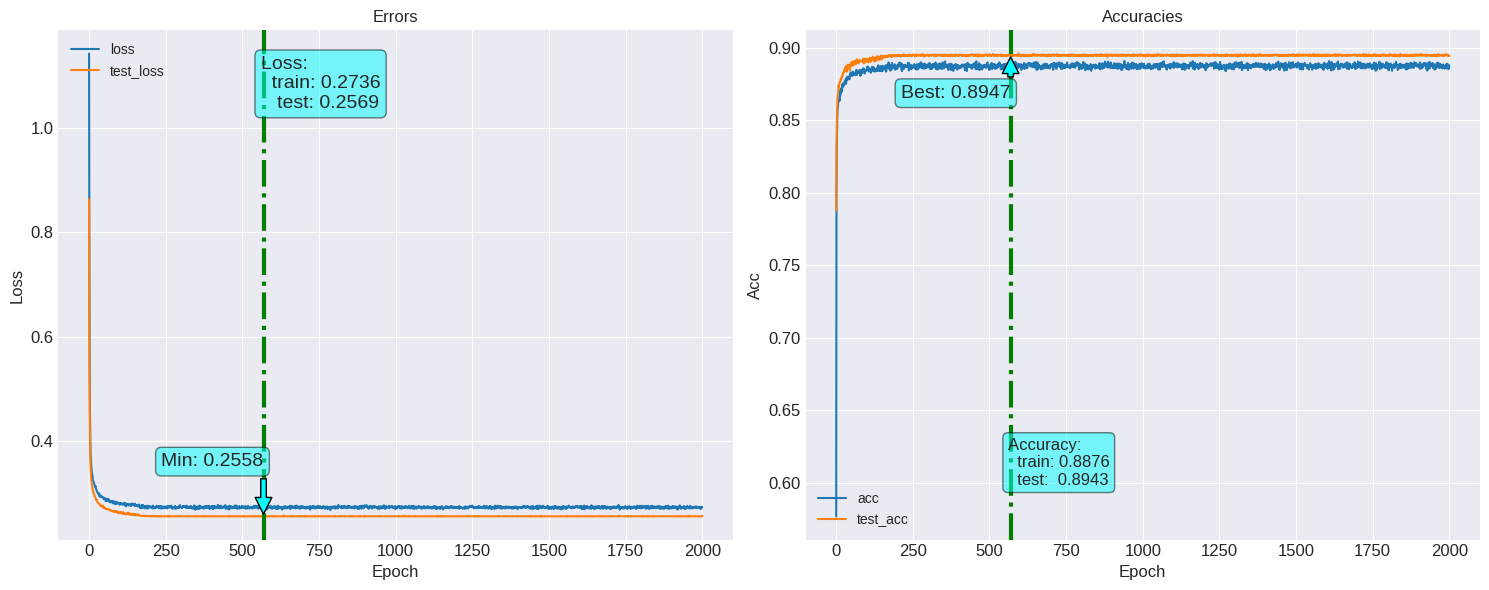

In [ ]:
fn_plot_torch_hist(loss_df)

In [ ]:
outputs = model(train_X)
outputs

tensor([[ -9.1889,  -1.4154,   4.0168,  -3.9472],
        [ -9.7199,  -0.1410,   3.4682,  -2.0514],
        [-12.2108,  -8.7901,   4.6774,   3.7316],
        ...,
        [ 15.1790,  -5.1124,  -6.0907,  -8.9084],
        [-10.2485,  -7.8976,   3.5700,   3.7847],
        [-15.3636,  -9.6460,   0.7615,   6.7401]], grad_fn=<AddmmBackward0>)

In [ ]:
outputs = model(train_X)
outputs.shape    #Tensor

torch.Size([256, 4])

In [ ]:
outputs = model(train_X)    #same as above because device was not showing device='cuda:0'
outputs.cpu()               #here we are converting it to cpu

tensor([[ -9.1889,  -1.4154,   4.0168,  -3.9472],
        [ -9.7199,  -0.1410,   3.4682,  -2.0514],
        [-12.2108,  -8.7901,   4.6774,   3.7316],
        ...,
        [ 15.1790,  -5.1124,  -6.0907,  -8.9084],
        [-10.2485,  -7.8976,   3.5700,   3.7847],
        [-15.3636,  -9.6460,   0.7615,   6.7401]], grad_fn=<AddmmBackward0>)

In [ ]:
outputs = model(train_X)    #same as above because device was not showing in the output
outputs.cpu().detach().numpy()  #.cpu() is not required

array([[ -9.188899  ,  -1.4154383 ,   4.0167956 ,  -3.94718   ],
       [ -9.719863  ,  -0.14098503,   3.4682188 ,  -2.0514095 ],
       [-12.21077   ,  -8.790142  ,   4.6773763 ,   3.7315505 ],
       ...,
       [ 15.179027  ,  -5.112374  ,  -6.0906906 ,  -8.908446  ],
       [-10.248512  ,  -7.8975616 ,   3.5699706 ,   3.7846797 ],
       [-15.363572  ,  -9.6460285 ,   0.7615052 ,   6.7401013 ]],
      dtype=float32)

In [ ]:
outputs = model(train_X)
y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
y_pred

array([2, 2, 2, 0, 2, 3, 1, 2, 2, 1, 3, 3, 2, 1, 1, 2, 2, 1, 0, 1, 2, 1,
       1, 1, 3, 1, 1, 2, 2, 1, 3, 2, 2, 1, 2, 2, 2, 0, 1, 3, 1, 0, 2, 1,
       1, 2, 2, 2, 3, 0, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 3, 2, 3, 0, 2, 1,
       3, 1, 2, 3, 0, 0, 0, 3, 1, 1, 1, 3, 2, 1, 2, 1, 2, 2, 2, 2, 0, 0,
       1, 3, 2, 2, 2, 0, 3, 2, 2, 2, 0, 1, 2, 1, 2, 0, 0, 2, 2, 2, 1, 2,
       1, 1, 1, 2, 3, 3, 2, 1, 0, 3, 3, 2, 2, 2, 2, 2, 1, 3, 1, 2, 3, 3,
       2, 1, 2, 1, 1, 3, 3, 0, 0, 2, 1, 1, 1, 3, 0, 1, 1, 2, 2, 2, 2, 2,
       0, 2, 3, 2, 1, 1, 2, 2, 2, 1, 2, 3, 1, 3, 1, 1, 1, 2, 3, 3, 3, 1,
       3, 3, 1, 1, 2, 2, 1, 2, 0, 2, 3, 3, 0, 2, 0, 2, 2, 2, 2, 2, 3, 2,
       1, 1, 2, 1, 1, 1, 2, 0, 1, 0, 1, 3, 2, 2, 1, 2, 3, 3, 2, 2, 1, 3,
       1, 0, 1, 1, 3, 1, 0, 3, 3, 0, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 2,
       0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 0, 0, 3, 3])

In [ ]:
y_train

array([1, 2, 1, ..., 0, 0, 0], dtype=int8)

In [ ]:
print(classification_report(train_y.cpu().numpy(), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       0.90      1.00      0.95        70
           2       0.86      0.85      0.85        97
           3       0.87      0.78      0.82        58

    accuracy                           0.89       256
   macro avg       0.91      0.91      0.90       256
weighted avg       0.89      0.89      0.89       256



In [ ]:
y_true = train_y.cpu().numpy()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       0.90      1.00      0.95        70
           2       0.86      0.85      0.85        97
           3       0.87      0.78      0.82        58

    accuracy                           0.89       256
   macro avg       0.91      0.91      0.90       256
weighted avg       0.89      0.89      0.89       256



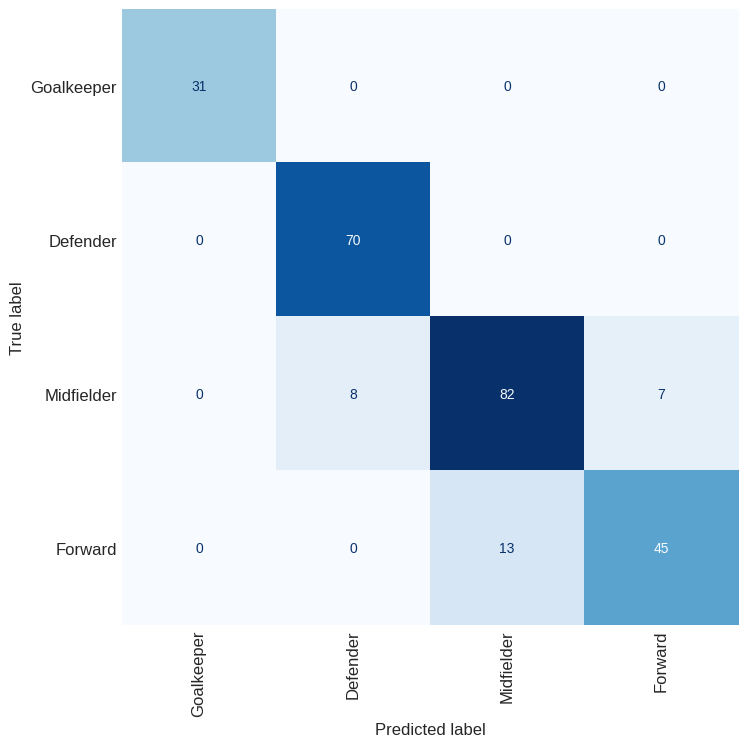

In [ ]:
cm= confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels.values())
disp.plot(cmap='Blues', xticks_rotation='vertical', colorbar=False)
plt.grid(False)
plt.show()



In [ ]:
''' Define custom dataset'''
class FifaDataset(Dataset):
  def __init__(self, X, y):
    super(FifaDataset,self).__init__()
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.long)
  def __len__(self):
    return(len(self.X))
  def __getitem__(self, idx):
    return(self.X[idx], self.y[idx])

In [ ]:
train_dataset = FifaDataset(X_train, y_train)

train_loader = DataLoader(dataset=train_dataset,
                          shuffle=True,
                          batch_size=BATCH_SIZE, )

X_batch, y_batch = next(iter(train_loader))
X_batch.shape, y_batch.shape


In [ ]:
test_dataset = FifaDataset(X_train, y_train)

test_loader = DataLoader(dataset=train_dataset,
                          shuffle=True,
                          batch_size=BATCH_SIZE, )

X_batch, y_batch = next(iter(train_loader))
X_batch.shape, y_batch.shape
